In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: TkAgg


# Lab 7

## Oscilloscope Data

In [77]:
# 10 & 11: base values, HF & LF, Vdmax = 74.4V, Iin = 1.38A & 1.38A (?), Vout = 9.89V & 9.95V
# 12 & 13: HF resistor (10 ohm), HF & LF, Iin = 1.39A & 1.39A,Vdmax = 67.0V, Vout =  9.98V & 9.97V
# 14 & 15: LF resistor (100 ohm), LF & HF, Iin = 1.33A & 1.38A, Vdmax = 72.1, Vout = 9.75V & 9.93V
# Vin = 18V

# 49: failed, 1.39A, 9.93V Vd = 54.4
# 50: for funsies, 6.5V, 0.62A
# 51: FINAL, 9.93Vout, 1.39A Iin,  Vd = 54V

(df_baseline_hf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile10.csv", ch1 = "Vsh_baseline_hf", ch2 = "Vd_baseline_hf")
(df_baseline_lf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile11.csv", ch1 = "Vsh_baseline_lf", ch2 = "Vd_baseline_lf", shift = -79.5e-6)
(df_hf_snub_hf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile12.csv", ch1 = "Vsh_hf_snub_hf", ch2 = "Vd_hf_snub_hf")
(df_hf_snub_lf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile13.csv", ch1 = "Vsh_hf_snub_lf", ch2 = "Vd_hf_snub_lf", shift = 0.2e-6)
(df_lf_snub_hf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile15.csv", ch1 = "Vsh_lf_snub_hf", ch2 = "Vd_lf_snub_hf")
(df_lf_snub_lf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile14.csv", ch1 = "Vsh_lf_snub_lf", ch2 = "Vd_lf_snub_lf")
(df_clamp, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile51.csv", ch1 = "Vsh", ch2 = "Vd", ch3 = "Vdiode", shift = 130e-9)

# Combine all variables into one for convenience
# df = df_4V_zoom1.set_index("t").join([df_4V.set_index("t"), df_7V.set_index("t"), df_9V.set_index("t"), df_9V_zoom1.set_index("t"), df_9V_zoom2.set_index("t")]).reset_index()
df_hf = df_baseline_hf.set_index("t").join([df_hf_snub_hf.set_index("t"), df_lf_snub_hf.set_index("t")]).reset_index()
df_lf = df_baseline_lf.set_index("t").join([df_hf_snub_lf.set_index("t"), df_lf_snub_lf.set_index("t")]).reset_index()
# df_clamp

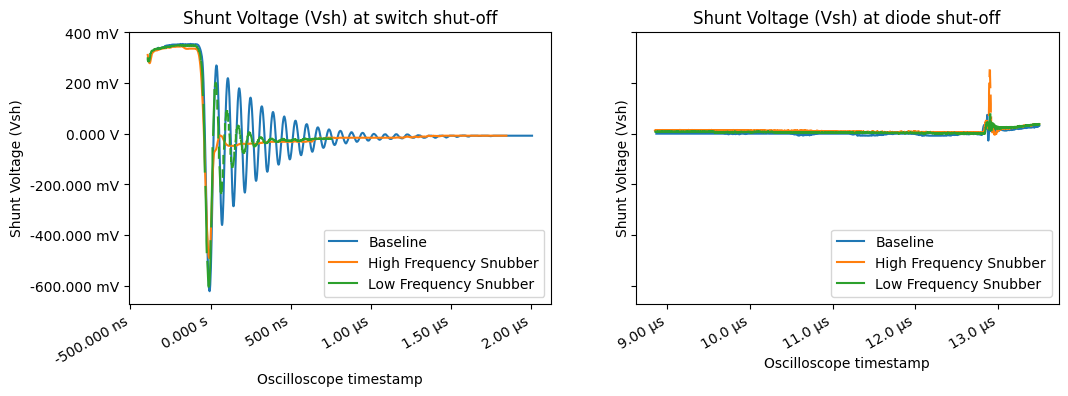

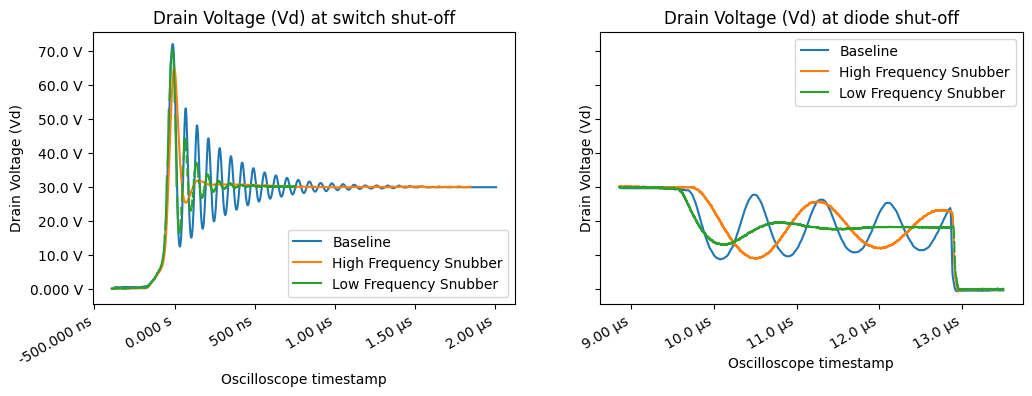

In [78]:
# Vshunt
df_hf_zoom = df_hf
df_lf_zoom = df_lf[(df_lf["t"] > 8e-6) & (df_lf["t"] < 13.5e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) at switch shut-off", ax = ax1)
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vsh_baseline_hf"], label = "Baseline")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vsh_hf_snub_hf"], label = "High Frequency Snubber")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vsh_lf_snub_hf"], label = "Low Frequency Snubber")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) at diode shut-off", ax = ax2)
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vsh_baseline_lf"], label = "Baseline")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vsh_hf_snub_lf"], label = "High Frequency Snubber")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vsh_lf_snub_lf"], label = "Low Frequency Snubber")
ax2.legend(loc = "lower right")

# Vd
df_hf_zoom = df_hf
df_lf_zoom = df_lf[(df_lf["t"] > 8e-6) & (df_lf["t"] < 13.5e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) at switch shut-off", ax = ax1)
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vd_baseline_hf"], label = "Baseline")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vd_hf_snub_hf"], label = "High Frequency Snubber")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vd_lf_snub_hf"], label = "Low Frequency Snubber")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) at diode shut-off", ax = ax2)
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vd_baseline_lf"], label = "Baseline")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vd_hf_snub_lf"], label = "High Frequency Snubber")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vd_lf_snub_lf"], label = "Low Frequency Snubber")
ax2.legend(loc = "upper right")

**High-Frequency Ring (after switch shut-off)**

The high-frequency snubber design works exceptionally well; the high frequency oscillation is very close to critically damped. Whereas the baseline signal oscillates for at least 1us, the damped signal is completely attenuated within a quarter of that time. The low-frequency snubber design is less effective at dampening the high-freuqency ringing, but it is nonetheless significantly better than the baseline.

**Low-Frequency Ring (after diode shut-off)**

The high-frequency snubber significantly changes the period and phase shift of the low-frequency ring relative to the baseline, but it provides little dampening. The low-frequency snubber again is nearly critically damped and effectively halts the oscillation within about 2us, well before the switch turns on again.

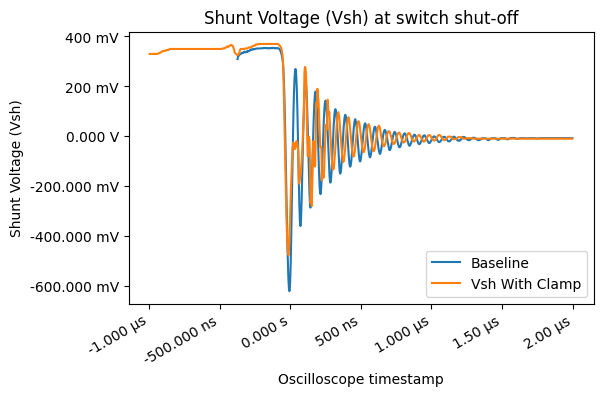

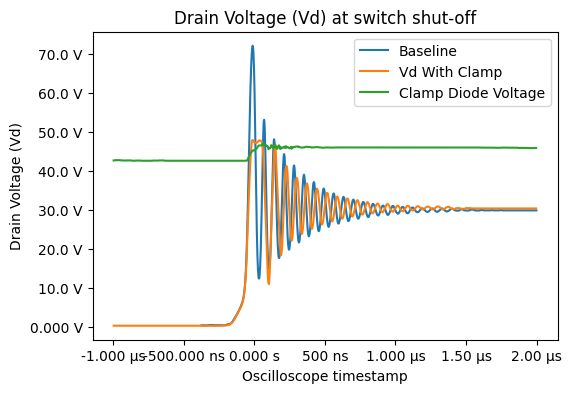

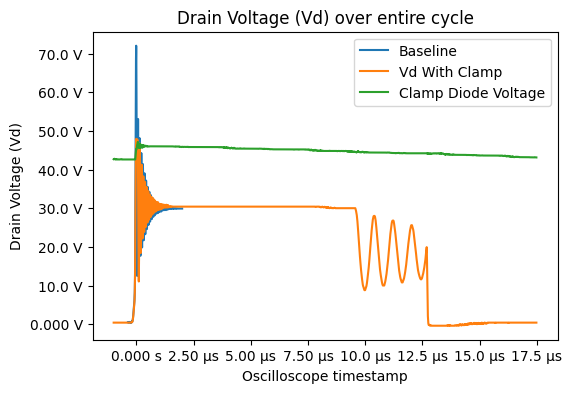

In [91]:
# Vd
bounds = (-1e-6, 2e-6)
df_clamp_zoom = df_clamp
df_baseline_zoom = df_baseline_hf
df_clamp_zoom = df_clamp[(df_clamp["t"] > bounds[0]) & (df_clamp["t"] < bounds[1])]
df_baseline_zoom = df_baseline_hf[(df_baseline_hf["t"] > bounds[0]) & (df_baseline_hf["t"] < bounds[1])]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (6, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) at switch shut-off", ax = ax1)
ax1.plot(df_baseline_zoom["t"], df_baseline_zoom["Vsh_baseline_hf"], label = "Baseline")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vsh"], label = "Vsh With Clamp")
ax1.legend(loc = "lower right")

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (6, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) at switch shut-off", ax = ax1)
ax1.plot(df_baseline_zoom["t"], df_baseline_zoom["Vd_baseline_hf"], label = "Baseline")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vd"], label = "Vd With Clamp")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vdiode"], label = "Clamp Diode Voltage")
ax1.legend(loc = "upper right")

df_clamp_zoom = df_clamp[(df_clamp["t"] > bounds[0]) & (df_clamp["t"] < 40e-6)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (6, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) over entire cycle", ax = ax1)
ax1.plot(df_baseline_zoom["t"], df_baseline_zoom["Vd_baseline_hf"], label = "Baseline")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vd"], label = "Vd With Clamp")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vdiode"], label = "Clamp Diode Voltage")
ax1.legend(loc = "upper right")

The clamp voltage behaves exactly as expected. It cuts off the first one or two peaks of the drain voltage ringing when it exceeds 45V. Once the amplitude stays consistently below the clamp threshold, the ringing continues as normal. Note that this data was taken with the clamp in place but with the snubbers removed.